## Load Packages

In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
import rioxarray
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.dates as mdates
import sys
import deafrica_waterbodies
import datacube
import matplotlib.ticker as plticker


from deafrica_tools.dask import create_local_dask_cluster
from deafrica_tools.datahandling import wofs_fuser, mostcommon_crs
from deafrica_tools.plotting import plot_wofs
from deafrica_tools.spatial import xr_rasterize
from deafrica_waterbodies.make_timeseries import generate_timeseries_from_wofs_ls
from datacube.utils import masking
from IPython.display import HTML
dc = datacube.Datacube(app="wb_anim")

In [2]:
create_local_dask_cluster()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/mickwelli@bigpond.com/proxy/8787/status,
Dashboard: /user/mickwelli@bigpond.com/proxy/8787/status,Workers: 1
Total threads: 4,Total memory: 26.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40531,Workers: 1
Dashboard: /user/mickwelli@bigpond.com/proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 26.21 GiB
Comm: tcp://127.0.0.1:33767,Total threads: 4
Dashboard: /user/mickwelli@bigpond.com/proxy/44113/status,Memory: 26.21 GiB
Nanny: tcp://127.0.0.1:34757,


## Bring in waterbodies polygons

In [ ]:
#https://deafrica-waterbodies-dev.s3.af-south-1.amazonaws.com/0-0-1/shapefile/senegalbasinwaterbodies.shx
#aws s3 ls --region=af-south-1 s3://deafrica-waterbodies-dev/0-0-1/timeseries/  --no-sign-request

In [ ]:
a = gpd.read_file('data/senegalbasinwaterbodies.shp')

In [ ]:
b = a.mask(a.eq('None'))

In [ ]:
b = b.to_crs('EPSG:4326').cx[35:35.4, -6.25:-5.98]

In [ ]:
b.explore()

### Select waterbody polygon from exploration

In [ ]:
UID_sel = 'edz5cm96j'

In [ ]:
r = b[b['UID']==UID_sel]#.assign(ID="abcd5_baring_55")

In [ ]:
r.to_file('data/sel_sngl_1.shp')

<Axes: >

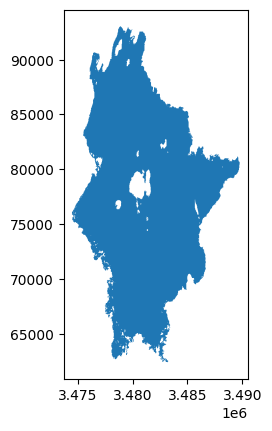

In [3]:
r = gpd.read_file('data/Baringo.shp')
c=r.to_crs('EPSG:6933')
c.plot()

In [ ]:
c

### Generate timeseries from WOfS

In [4]:
import datetime
import logging
import os
from pathlib import Path

import datacube
import dateutil
import fsspec
import geopandas as gpd
import numpy as np
import pandas as pd
from datacube.utils.geometry import Geometry
from deafrica_tools.datahandling import wofs_fuser
from deafrica_tools.spatial import xr_rasterize
from odc.stats.model import DateTimeRange
from tqdm.auto import tqdm

from deafrica_waterbodies.id_field import guess_id_field
from deafrica_waterbodies.io import check_dir_exists, check_file_exists, check_if_s3_uri

_log = logging.getLogger(__name__)

def generate_timeseries_from_wofs_ls_mw(
    waterbodies_vector_file: str | Path,
    output_directory: str | Path,
    use_id: str,
    missing_only: bool = False,
    time_span: str = "all",
    temporal_range: str = None,
    subset_polygons_ids: list[str] = [],
):
    """
    Function to generate a timeseries csv file for each waterbody polygon in the
    `waterbodies_vector_file`. The timeseries csv file for a waterbody polygon
    shows the percentage of the waterbody that was wet for each `wofs_ls`
    timestep in the time range specified.

    Parameters
    ----------
    waterbodies_vector_file : str | Path
        Path to the water body polygons vector file to generate the time series
        for.
    output_directory : str | Path
        File URI or S3 URI of the directory to write the timeseries csv files to.
    use_id : str
        Name of the column/field in the waterbody polygon vector file containing
        the unique key identifier for each waterbody polygon.
    missing_only : bool, optional
        If set to True, generate the timeseries for the waterbody polygons whose
        timeseries csv file is not present in the output directory specified,
        by default False
    time_span : str, optional
        Time span to generate the timeseries for. Valid options are `"all"`,
        `"custom"`, or `"append"`,  by default "all"
    temporal_range: str | None, optional
        Time range to generate the timeseries for, if `time_span` is set to
        `"custom"`. Example '2020-05--P1M' for the month of May 2020, by default
        None
    subset_polygons_ids : list[str], optional
        A list of ids of the waterbodies to generate the timeseries for from
        the waterbodies in `waterbodies_vector_file`.
    """
    # Support pathlib paths.
    waterbodies_vector_file = str(waterbodies_vector_file)
    output_directory = str(output_directory)

    # Create the output directory if it does not exist.
    if not check_dir_exists(output_directory):
        if check_if_s3_uri(output_directory):
            fs = fsspec.filesystem("s3")
        else:
            fs = fsspec.filesystem("file")

        fs.mkdirs(output_directory, exist_ok=True)
        _log.info(f"Created directory {output_directory}")

    # We will be using wofs_ls data.
    output_crs = "EPSG:6933"
    resolution = (-100, 100)
    dask_chunks = {"x": 3200, "y": 3200, "time": 1}

    # Load the waterbody polygons.
    try:
        polygons_gdf = gpd.read_file(waterbodies_vector_file)
    except Exception as error:
        _log.exception(f"Could not read file {waterbodies_vector_file}")
        raise error
    else:
        id_field = guess_id_field(polygons_gdf, use_id)
        _log.info(f"Guessed ID field: {id_field}")
        polygons_gdf.set_index(id_field, inplace=True)

    # Reproject to a projected crs.
    polygons_gdf = polygons_gdf.to_crs(output_crs)
    assert polygons_gdf.crs.is_projected

    # Select polygons using values in the id column.
    if subset_polygons_ids:
        polygons_gdf = polygons_gdf.loc[subset_polygons_ids]

    # Get the IDs for the water body polygons with no timeseries csv file in the
    # output directory.
    if missing_only:
        polygon_ids = get_polygon_ids_for_missing_timeseries(polygons_gdf, output_directory)
    else:
        polygon_ids = polygons_gdf.index.to_list()

    if not polygon_ids:
        _log.info("No polygons identified with missing timeseries.")
        return []
    else:
        _log.info(f"Number of polygons to generate timeseries for {len(polygons_gdf)}.")

        # Time span is mutually exclusive with temporal_range.
        valid_time_span_options = ["all", "custom", "append"]

        if time_span not in valid_time_span_options:
            _log.error(f"{time_span} is an invalid time span.")
            raise ValueError(
                f"Please select a valid time span option: {' '.join(valid_time_span_options)}"
            )

        # Checks.
        if time_span == "all":
            if temporal_range:
                _log.error("Time span set to `all` yet temporal range specified.")
                raise ValueError("If time span is set to 'all' do not pass a temporal range.")
            else:
                start_date_str = "1984"
                end_date_str = datetime.datetime.now().strftime("%Y-%m-%d")
        elif time_span == "append":
            # Start date will be defined in polygons_id loop.
            end_date_str = datetime.datetime.now().strftime("%Y-%m-%d")
        elif time_span == "custom":
            try:
                temporal_range_ = DateTimeRange(temporal_range)
            except ValueError:
                _log.exception(f"Failed to parse supplied temporal_range: '{temporal_range}'")
            else:
                start_date_str = temporal_range_.start.strftime("%Y-%m-%d")
                end_date_str = temporal_range_.end.strftime("%Y-%m-%d")

        # For logging purposes only.
        if time_span != "append":
            _log.info(
                f"Generating timeseries for the time range: {start_date_str} to {end_date_str}."
            )

        # Connect to the datacube
        dc = datacube.Datacube(app="deafricawaterbodies-timeseries")

        generated_timeseries_fps = []
        with tqdm(total=len(polygon_ids)) as bar:
            for poly_id in polygon_ids:
                # Parent directory for csv files.
                poly_timeseries_parent_dir = os.path.join(output_directory, poly_id[:4])
                if not check_dir_exists(poly_timeseries_parent_dir):
                    if check_if_s3_uri(poly_timeseries_parent_dir):
                        fs = fsspec.filesystem("s3")
                    else:
                        fs = fsspec.filesystem("file")
                    fs.mkdirs(poly_timeseries_parent_dir, exist_ok=True)
                    _log.info(f"Created directory {poly_timeseries_parent_dir}")

                # Polygon's timeseries file path.
                poly_timeseries_fp = os.path.join(poly_timeseries_parent_dir, f"{poly_id}.csv")

                if time_span == "append":
                    try:
                        last_observation_date = get_last_observation_date_from_csv(
                            poly_timeseries_fp
                        )
                    except FileNotFoundError:
                        start_date_str = "1984"
                        _log.info(
                            f"Could not find last observation date for polygon {poly_id}, defaulting to using the start date {start_date_str}."
                        )
                    else:
                        start_date = last_observation_date + dateutil.relativedelta.relativedelta(
                            days=1
                        )
                        start_date_str = start_date.strftime("%Y-%m-%d")

                time_range = (start_date_str, end_date_str)
                _log.info(
                    f"Generating timeseries for {poly_id} for the time range: {time_range[0]} to {time_range[1]}."
                )

                poly_geom = polygons_gdf.loc[poly_id].geometry
                poly_gdf = gpd.GeoDataFrame(geometry=[poly_geom], crs=output_crs)
                poly_geopolygon = Geometry(geom=poly_geom, crs=output_crs)

                # Load the Water Observations from Space.
                wofls_ds = dc.load(
                    product="wofs_ls",
                    geopolygon=poly_geopolygon,
                    time=time_range,
                    resolution=resolution,
                    output_crs=output_crs,
                    dask_chunks=dask_chunks,
                    resampling="nearest",
                    group_by="solar_day",
                    fuse_func=wofs_fuser,
                )

                # If no data is found.
                if not wofls_ds:
                    _log.info(
                        f"There is no data for {poly_id} for the time range: {time_range[0]} to {time_range[1]}."
                    )
                    continue
                else:
                    wofls_da = wofls_ds.water
                    # Mask the loaded WOfS data using the rasterized waterbody polygon,
                    # if the height and width of the bounding box of the waterbody polygon
                    # are large than the length of a pixel.
                    pixel_length = abs(resolution[0])  # should be a positive number.
                    if (
                        poly_geopolygon.boundingbox.height > pixel_length
                        and poly_geopolygon.boundingbox.width > pixel_length
                    ):
                        poly_mask = xr_rasterize(poly_gdf, wofls_da)
                        wofls_da_masked = wofls_da.where(poly_mask, np.nan)
                    else:
                        _log.info(
                            f"Water body polygon bounding box length and width are smaller than pixel length {pixel_length} metres."
                        )
                        wofls_da_masked = wofls_da

                    # Compute the array at this point.
                    wofls_da_masked = wofls_da_masked.compute()

                    # Get the area of each pixel.
                    pixel_area = pixel_length**2

                    # Get the number of pixels for the waterbody.
                    pixel_count = (~np.isnan(wofls_da_masked)).sum(["x", "y"])

                    # Apply WOfS bitmasking to the Water Observation Feature Layers
                    # See: the  Applying WOfS Bitmasking notebook in the
                    # Frequently_used_code folder in the
                    # digitalearthafrica/deafrica-sandbox-notebooks Github repository.

                    # Number of pixels observed to be valid (clear) and dry.
                    valid_and_dry_count = (wofls_da_masked == 0).sum(["x", "y"])
                    # Percentage of pixels observed to be valid (clear) and dry.
                    valid_and_dry_percentage = (valid_and_dry_count / pixel_count) * 100.0
                    # Area covered by valid (clear) and dry pixels.
                    valid_and_dry_area = valid_and_dry_count * pixel_area

                    # Number of pixels observed to be valid (clear) and wet.
                    valid_and_wet_count = (wofls_da_masked == 128).sum(["x", "y"])
                    # Percentage of pixels observed to be valid (clear) and wet.
                    valid_and_wet_percentage = (valid_and_wet_count / pixel_count) * 100.0
                    # Area covered by valid (clear) and wet pixels.
                    valid_and_wet_area = valid_and_wet_count * pixel_area

                    # Number of valid (clear) pixels.
                    valid_count = valid_and_dry_count + valid_and_wet_count

                    # Number of invalid (not clear) pixels.
                    invalid_count = pixel_count - valid_count
                    # Area covered by invalid (not clear) pixels.
                    invalid_area = invalid_count * pixel_area
                    # Percentage of invalid pixels.
                    invalid_percentage = (invalid_count / pixel_count) * 100.0

                    # Create dataframes from the xarray.DataArrays.
                    valid_and_wet_percentage_df = valid_and_wet_percentage.to_dataframe(
                        name="pc_wet"
                    ).drop(columns="spatial_ref", errors="ignore")
                    valid_and_wet_count_df = valid_and_wet_count.to_dataframe(name="px_wet").drop(
                        columns="spatial_ref", errors="ignore"
                    )
                    valid_and_wet_area_df = valid_and_wet_area.to_dataframe(
                        name="area_wet_m2"
                    ).drop(columns="spatial_ref", errors="ignore")
                    valid_and_dry_percentage_df = valid_and_dry_percentage.to_dataframe(
                        name="pc_dry"
                    ).drop(columns="spatial_ref", errors="ignore")
                    valid_and_dry_count_df = valid_and_dry_count.to_dataframe(name="px_dry").drop(
                        columns="spatial_ref", errors="ignore"
                    )
                    valid_and_dry_area_df = valid_and_dry_area.to_dataframe(
                        name="area_dry_m2"
                    ).drop(columns="spatial_ref", errors="ignore")
                    invalid_percentage_df = invalid_percentage.to_dataframe(name="pc_invalid").drop(
                        columns="spatial_ref", errors="ignore"
                    )
                    invalid_count_df = invalid_count.to_dataframe(name="px_invalid").drop(
                        columns="spatial_ref", errors="ignore"
                    )
                    invalid_area_df = invalid_area.to_dataframe(name="area_invalid_m2").drop(
                        columns="spatial_ref", errors="ignore"
                    )
                    time_df = wofls_da_masked.time.to_dataframe(name="time").drop(
                        columns="spatial_ref", errors="ignore"
                    )

                    # Merge the individual dataframes into a single dataframe.
                    timeseries_df = pd.concat(
                        [
                            valid_and_wet_percentage_df,
                            valid_and_wet_count_df,
                            valid_and_wet_area_df,
                            valid_and_dry_percentage_df,
                            valid_and_dry_count_df,
                            valid_and_dry_area_df,
                            invalid_percentage_df,
                            invalid_count_df,
                            invalid_area_df,
                            time_df
                        ],
                        ignore_index=False,
                        join="outer",
                        axis="columns",
                    )

                    # Set pc_wet and pc_dry values to nan, which will be used if insufficient pixels are observed.
                    timeseries_df["pc_wet"] = timeseries_df.apply(
                        lambda row: np.nan if row.pc_invalid > 10.0 else row.pc_wet, axis=1
                    )
                    timeseries_df["pc_dry"] = timeseries_df.apply(
                        lambda row: np.nan if row.pc_invalid > 10.0 else row.pc_dry, axis=1
                    )

                    # Parse the datetime index.
                    timeseries_df.index = timeseries_df.time

                    # Sort by date.
                    timeseries_df.sort_index(ascending=True, inplace=True)

                    if time_span == "append":
                        # Append the DataFrame to an existing csv file.
                        timeseries_df.to_csv(
                            poly_timeseries_fp, mode="a", index=False, header=False
                        )
                        _log.info(f"Timeseries appended to csv file {poly_timeseries_fp}")
                    else:
                        # Write the DataFrame to a new csv file.
                        timeseries_df.to_csv(poly_timeseries_fp, mode="w", index=False)
                        _log.info(f"Timeseries written to file {poly_timeseries_fp}")

                    generated_timeseries_fps.append(poly_timeseries_fp)
                bar.update(1)
            _log.info(f"Done! Generated timeseries for {len(polygon_ids)} polygons.")
            return generated_timeseries_fps


In [6]:
generate_timeseries_from_wofs_ls_mw('data/Baringo.shp', output_directory='data', use_id='ID')

  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


['data/abcd/abcd55.csv']

### Loads WOfS annual for visualisation

In [ ]:
lat_range = (r.total_bounds[1], r.total_bounds[3])
lon_range = (r.total_bounds[0], r.total_bounds[2])

query = {
    'x': lon_range,
    'y': lat_range,
    'time': ('2000-01-01', '2022-12-31'),
    'resolution': (-150, 150)
}

wofs= dc.load(product = 'wofs_ls_summary_annual',
               output_crs = 'epsg:6933',
               **query)
wofs

In [ ]:
wofs.frequency.isel(time=10).plot()

In [ ]:
mask = xr_rasterize(c, wofs)
clipped_wofs = wofs.where(mask)

clipped_wofs.frequency.isel(time=8).plot()

### Bring in longer time series generated by WOfS

In [7]:
ts2 = pd.read_csv('data/abcd/abcd55.csv')

ts2 = ts2.set_index(pd.DatetimeIndex(pd.to_datetime(ts2['time']).dt.strftime('%Y-%m-%d')))
ts2

,pc_wet,px_wet,area_wet_m2,pc_dry,px_dry,area_dry_m2,pc_invalid,px_invalid,area_invalid_m2,time
time,,,,,,,,,,
1984-04-12,NaN,816,8160000,NaN,609,6090000,93.707776,21222,212220000,1984-04-12 07:15:44.249069
1984-05-30,62.507175,14156,141560000,34.719830,7863,78630000,2.772994,628,6280000,1984-05-30 07:16:34.213031
1984-06-15,65.244845,14776,147760000,34.688921,7856,78560000,0.066234,15,150000,1984-06-15 07:16:52.221006
1984-07-01,65.094715,14742,147420000,34.812558,7884,78840000,0.092728,21,210000,1984-07-01 07:17:04.559025
1984-07-17,65.231598,14773,147730000,34.706584,7860,78600000,0.061818,14,140000,1984-07-17 07:17:20.464013
...,...,...,...,...,...,...,...,...,...,...
2023-08-20,NaN,14217,142170000,NaN,1156,11560000,32.119044,7274,72740000,2023-08-20 05:35:33.101138
2023-08-22,92.895306,21038,210380000,7.025213,1591,15910000,0.079481,18,180000,2023-08-22 07:48:24.498487
2023-08-30,92.811410,21019,210190000,7.109109,1610,16100000,0.079481,18,180000,2023-08-30 07:48:34.077718


In [ ]:
#ts2 = ts2.pc_wet.loc['2000-01-01':'2021-12-31'].resample('3M').mean().interpolate()
#ts2

In [8]:
tsw = ts2.loc['2000-01-01':'2021-12-31'].area_wet_m2.resample('3M').mean().interpolate()/1000000
tsw

time
2000-01-31     84.970000
2000-04-30    119.800000
2000-07-31    111.890000
2000-10-31     61.475000
2001-01-31    112.596667
                 ...    
2021-01-31    149.016000
2021-04-30    147.190000
2021-07-31    134.461667
2021-10-31    135.399091
2022-01-31    142.996250
Freq: 3M, Name: area_wet_m2, Length: 89, dtype: float64

In [ ]:
#ts2.to_csv('data/Morocco_dam_ts.csv')

In [ ]:
clipped_wofs_rs = clipped_wofs.resample(time="3M").interpolate("linear").sel(
    time=slice('2000-09-01', '2022-12-31'))

In [ ]:
clipped_wofs_rs.frequency.isel(time=0).plot()

### Load annual geomedians for basemap

In [ ]:
lat_range = (r.total_bounds[1], r.total_bounds[3])
lon_range = (r.total_bounds[0], r.total_bounds[2])

ds = dc.load(product=["gm_ls5_ls7_annual", "gm_ls8_annual","gm_ls8_ls9_annual"],
             measurements=['red', 'green', 'blue'],
             x=lon_range,
             y=lat_range,
             resolution = (-150,150),
             dask_chunks={'time': 1, 'x': 3000, 'y': 3000},
             time= ('2000-01-01', '2022-12-31')
             ).compute()

ds

In [ ]:
ds = ds.resample(time="3M").interpolate("linear").sel(
    time=slice('2000-09-01', '2022-12-31'))

ds

### Check length of each dataset for animation

In [ ]:
print(len(ds.time))
print(len(clipped_wofs_rs.time))
print(len(ts2))

## Run animation

In [ ]:
# create a figure and axes
fig = plt.figure(figsize=(10,5))
ax1 = plt.subplot(122)   
ax2 = plt.subplot(121)

ax1.set_title("Waterbodies Timeseries")
ax1.set_xlabel("Date")
ax1.set_ylabel("Surface water extent ($km^2$)")
years = mdates.YearLocator() 
ax1.xaxis.set_major_locator(years)
ax1.tick_params(axis='x', labelrotation = 45)

bands=['red', 'green', 'blue']

cax = (ds[bands].isel(time=0).to_array().transpose('y','x','variable').squeeze(
    ).clip(0,3000)/np.max(
    ds[bands].isel(time=0).to_array(
    ).transpose('y','x','variable').squeeze().clip(0,3000))).plot.imshow(rgb='variable', animated = True, robust=True, ax=ax2)
dax = clipped_wofs_rs.frequency[0,:,:].plot(cmap='Blues', ax=ax2)
c.plot(ax=ax2, edgecolor='black', color='none')

def update(num, x, y, line):
    dax.set_array(clipped_wofs_rs.frequency[num,:,:])
    cax.set_array((ds[bands].isel(time=num).to_array().transpose('y','x','variable')).squeeze().clip(0,3000)/np.max(
        ds[bands].isel(time=num).to_array().transpose('y','x','variable')).squeeze().clip(0,3000))
    ax2.set_title("Time = " + str(clipped_wofs_rs.frequency.coords['time'].values[(num)])[:12])
    line.set_data(x[:num], y[:num])
    return line,

x = tsw.index
y = tsw.values

line, = ax1.plot(x, y)

plt.tight_layout()

ani = animation.FuncAnimation(fig, update, len(ds.time), fargs=[x, y, line],
                              interval=200, blit=True)
ani.save('Baringo_improved.gif')

plt.close()
HTML(ani.to_html5_video())

## Static Images

In [ ]:

bands=['red', 'green', 'blue']

fig, ax = plt.subplots()
(ds[bands].isel(time=2).to_array().transpose('y','x','variable').squeeze(
    ).clip(0,3000)/np.max(
    ds[bands].isel(time=0).to_array(
    ).transpose('y','x','variable').squeeze().clip(0,3000))).plot.imshow(rgb='variable', robust=True, ax=ax)
clipped_wofs_rs.frequency[2,:,:].plot.pcolormesh(cmap='Blues', add_colorbar=False, ax=ax)
# set both tick marks and tick labels to size 0
ax.tick_params(which = 'both', size = 0, labelsize = 0)
ax.set_title("")
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_aspect("equal")
fig.savefig('Baringo_Map_2.png')

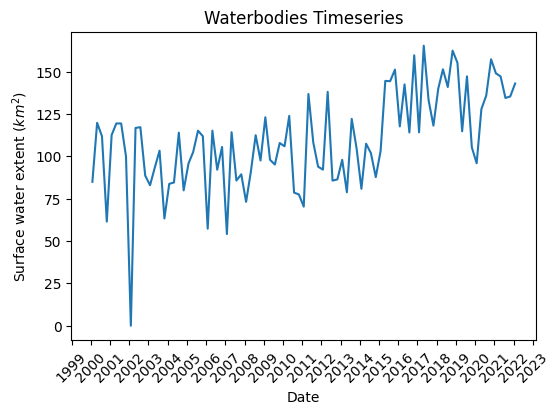

In [9]:
fig = plt.figure(figsize=(6,4))
ax1 = plt.subplot()   


ax1.set_title("Waterbodies Timeseries")
ax1.set_xlabel("Date")
ax1.set_ylabel("Surface water extent ($km^2$)")
ax1.tick_params(axis='x', labelrotation = 45)
years = mdates.YearLocator() 
ax1.xaxis.set_major_locator(years)
ax1.tick_params(axis='x', labelrotation = 45)

x = tsw.index
y = tsw.values

ax1.plot(x, y)

fig.savefig('Baringo_TS.png')